# Interictal Analysis - Neural Fragility

In the fragility perturbation model, we traditionally perturb the columns of the linear system matrix. However, assuming the system is not symmetric, then a row-perturbation provides an alternative view on how epileptic a region might be hypothesized.

In [1]:
import os
import re
import json
import random
import collections
from pprint import pprint
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import scipy

from eztrack.io import read_clinical_excel
from eztrack.utils import warn
from mne_bids import read_raw_bids, BIDSPath, get_entity_vals
from natsort import natsorted, index_natsorted, order_by_index
import scipy
import math

from eztrack.utils import logger, ClinicalColumnns, ClinicalContactColumns

sys.path.append('../')

from analysis.fragility.posthoc import read_perturbation_result, run_svd_viz

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
WORKSTATION = "home"

if WORKSTATION == "home":
    # bids root to write BIDS data to
    # the root of the BIDS dataset
    root = Path("/Users/adam2392/Dropbox/epilepsy_bids/")
    output_dir = root / 'derivatives' / 'interictal'

    figures_dir = output_dir / 'figures'

    # path to excel layout file - would be changed to the datasheet locally
    excel_fpath = Path(
        "/Users/adam2392/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
    )
elif WORKSTATION == "lab":
    root = Path("/home/adam2392/hdd/epilepsy_bids/")
    excel_fpath = Path(
        "/home/adam2392/hdd/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
    )

    # output directory
    output_dir = Path("/home/adam2392/hdd/epilepsy_bids") / 'derivatives' / 'interictal'

    # figures directory
    figures_dir = output_dir / 'figures'

figures_dir = root / 'derivatives' / 'rowvscol'
figures_dir.mkdir(exist_ok=True, parents=True)

In [13]:
SUBJECTS = [
#     'jh103',
#     'jh105'
    'pt1'
]

session = "presurgery"  # only one session
task = "interictal"
datatype = "ieeg"
acquisition = "ecog"  # or SEEG
extension = ".vhdr"

if acquisition == 'ecog':
    ignore_acquisitions = ['seeg']
elif acquisition == 'seeg':
    ignore_acquisitions = ['ecog']

reference = 'monopolar'
sfreq = None  # either resample or don't

# get the runs for this subject
all_subjects = get_entity_vals(root, "subject")

for subject in all_subjects:
    if subject not in SUBJECTS:
        continue
    ignore_subs = [sub for sub in all_subjects if sub != subject]
    all_tasks = get_entity_vals(root, "task", ignore_subjects=ignore_subs)
    ignore_tasks = [tsk for tsk in all_tasks if tsk != task]

    print(f"Analyzing {task} task for {subject}.")
    ignore_tasks = [tsk for tsk in all_tasks if tsk != task]
    runs = get_entity_vals(
        root, 'run', ignore_subjects=ignore_subs,
        ignore_tasks=ignore_tasks,
        ignore_acquisitions=ignore_acquisitions
    )
    print(f'Found {runs} runs for {task} task.')

    deriv_path = (output_dir
                  # /  'nodepth'
                  / '1000Hz'
                  / "fragility"
                  / reference
                  / f"sub-{subject}")
    
    for idx, run in enumerate(runs):
        # create path for the dataset
        bids_path = BIDSPath(
            subject=subject,
            session=session,
            task=task,
            run=run,
            datatype=datatype,
            acquisition=acquisition,
            suffix=datatype,
            root=root,
#             extension=extension,
        )
        source_basename = bids_path.basename
        description = 'perturbmatrix'
        col_result = read_perturbation_result(deriv_path, source_basename, description)
        
        description = 'rowperturbmatrix'
        row_result = read_perturbation_result(deriv_path, source_basename, description)
        
        pat_dict = read_clinical_excel(excel_fpath, subject=subject)
        
        # extract the SOZ channels
        soz_chs = pat_dict[ClinicalContactColumns.SOZ_CONTACTS.value]
        epz_chs = pat_dict[ClinicalContactColumns.SPREAD_CONTACTS.value]
        rz_chs = pat_dict[ClinicalContactColumns.RESECTED_CONTACTS.value]

        break
    break

Analyzing interictal task for pt1.
Found ['01', '02', '03', '04'] runs for interictal task.
TRYING TO READ RESULT FILENAME  sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy
Loading /Users/adam2392/Dropbox/epilepsy_bids/derivatives/interictal/1000Hz/fragility/monopolar/sub-pt1/sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, which exists: True
TRYING TO READ RESULT FILENAME  sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy
Loading /Users/adam2392/Dropbox/epilepsy_bids/derivatives/interictal/1000Hz/fragility/monopolar/sub-pt1/sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, which exists: True


(84, 3240) (84, 3240)
(84,)


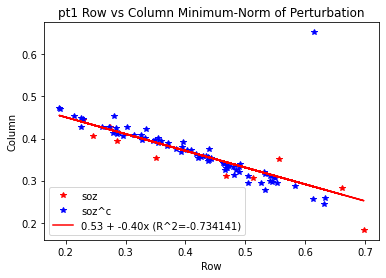

In [14]:
# do plot
row_pert_mats = row_result.get_data()
col_pert_mats = col_result.get_data()

print(col_pert_mats.shape, row_pert_mats.shape)

col_avg = col_pert_mats.mean(axis=1)
row_avg = row_pert_mats.mean(axis=1)

print(col_avg.shape)

linreg = scipy.stats.linregress(row_avg, col_avg)

soz_inds = [idx for idx, ch in enumerate(row_result.ch_names) if ch in soz_chs]
nsoz_inds = [idx for idx in range(len(row_result.ch_names)) if idx not in soz_inds]

# plot
fig, ax = plt.subplots()

for inds, marker, label in zip([soz_inds, nsoz_inds], ['r*', 'b*'], ['soz', 'soz^c']):
    ax.plot(row_avg[inds], col_avg[inds], marker, label=label)
ax.plot(row_avg, linreg.intercept + linreg.slope*row_avg, 'r', 
        label=f'{linreg.intercept:.2f} + {linreg.slope:.2f}x (R^2={linreg.rvalue:3f})')
ax.set(title=f'{subject} Row vs Column Minimum-Norm of Perturbation',
      xlabel='Row', ylabel='Column')
ax.legend()

fig.savefig(figures_dir / f'{subject}-rowvscol_minnorm.pdf', 
            bbox_inches='tight')

(84, 3240) (84, 3240)
(84,)


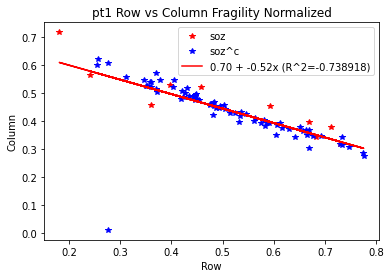

In [46]:
# do plot
_row_result = row_result.copy()
_col_result = col_result.copy()
_row_result.normalize()
_col_result.normalize()
row_pert_mats = _row_result.get_data()
col_pert_mats = _col_result.get_data()

print(col_pert_mats.shape, row_pert_mats.shape)

col_avg = col_pert_mats.mean(axis=1)
row_avg = row_pert_mats.mean(axis=1)

print(col_avg.shape)

linreg = scipy.stats.linregress(row_avg, col_avg)

# plot
fig, ax = plt.subplots()
for inds, marker, label in zip([soz_inds, nsoz_inds], ['r*', 'b*'], ['soz', 'soz^c']):
    ax.plot(row_avg[inds], col_avg[inds], marker, label=label)
ax.plot(row_avg, linreg.intercept + linreg.slope*row_avg, 'r', 
        label=f'{linreg.intercept:.2f} + {linreg.slope:.2f}x (R^2={linreg.rvalue:3f})')
ax.set(
    title=f'{subject} Row vs Column Fragility Normalized',
    xlabel='Row', ylabel='Column')
ax.legend()

fig.savefig(figures_dir / f'{subject}-rowvscol_fragility.pdf', 
            bbox_inches='tight')

<AxesSubplot:>

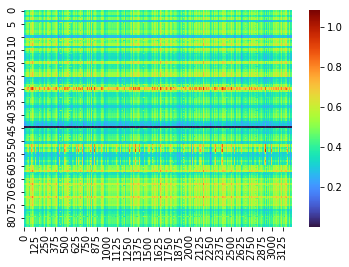

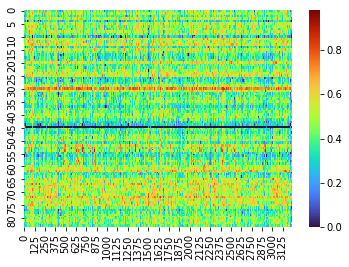

In [15]:
_row_result = row_result.copy()
_col_result = col_result.copy()
_row_result.normalize()
_col_result.normalize()
row_pert_mats = _row_result.get_data()
col_pert_mats = _col_result.get_data()

heatmap = run_svd_viz(col_pert_mats, _col_result.ch_names, fname='')
row_heatmap = run_svd_viz(row_pert_mats, _col_result.ch_names, fname='')


sns.heatmap(heatmap, cmap='turbo')

plt.figure()
sns.heatmap(col_pert_mats, cmap='turbo')

(84,)


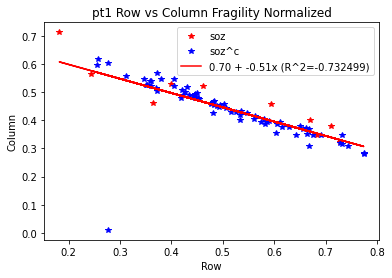

In [16]:
# do plot
col_avg = heatmap.mean(axis=1)
row_avg = row_heatmap.mean(axis=1)

print(col_avg.shape)

linreg = scipy.stats.linregress(row_avg, col_avg)

# plot
fig, ax = plt.subplots()
for inds, marker, label in zip([soz_inds, nsoz_inds], ['r*', 'b*'], ['soz', 'soz^c']):
    ax.plot(row_avg[inds], col_avg[inds], marker, label=label)
ax.plot(row_avg, linreg.intercept + linreg.slope*row_avg, 'r', 
        label=f'{linreg.intercept:.2f} + {linreg.slope:.2f}x (R^2={linreg.rvalue:3f})')
ax.set(
    title=f'{subject} Row vs Column Fragility Normalized',
    xlabel='Row', ylabel='Column')
ax.legend()

# fig.savefig(figures_dir / f'{subject}-rowvscol_fragility.pdf', 
#             bbox_inches='tight')